# News Mood Challenge

The objective of this challenge is to pull the 100 most recent tweets of seveal news sources and run VADER sentiment analysis on each. Compound scores are then visualized individually and as a whole to see what meaning can be derived from these scores.

### Analysis

Visualization of each individual sentiment score saw a small concentration of neutral scores upon running, but no other distinct trends emerge. Considering that these analyses are run on news sources, one might wonder what this implies about journalistic objectivity. Considering that objectivity is a central tennant of journalism ethics, one would hope to see a such a concentration. However, contents of the news itself would likely influence these scores as well.

This program was run the day after the 2018 US Midterm Elections, so it was a big news day. Considering the known partisan biases of Fox News and CNN, it is interesting to see that their compound sentiment scores occupied the upper and lower limits of the data: Fox News had the most positve score, and CNN had the most negative score. Among the headlines: Democrats took back the House of Representatives, Attorney General Jeff Sessions resigned, and Trump held one of his most combative press conferences to date. One wonders what impact these events had on the tweets coming from these sources.

In [1]:
#import necessary modules and info
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

from config import (consumer_key, 
                    consumer_secret, 
                    access_token, 
                    access_token_secret)

In [2]:
#authenticate tweepy
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [3]:
#compile list of twitter handles through which to loop
handles = ["@BBCNews", "@CBSNews", "@CNN", "@FoxNews", "@nytimes"]

#create a list to hold dictionaries of the sentiment analysis resules
s_scores = []

#create a variable to store the oldest tweet id for the loop
ot = None

In [4]:
#loop through the news organizations
for handle in handles:
    
    #create counter for tabulating tweets
    c = 1
    
    #loop through 5 pages (20 tweets per page) of tweets to acquire 100 tweets
    for x in range(5):
        tweets = api.user_timeline(handle, max_id = ot)
    
        #loop through the tweets themselves
        for t in tweets:
            
            #run Vader analysis on the tweet
            scores = analyzer.polarity_scores(t["text"])
            
            #add dictionary of scores to the list along with the media source date stamp
            s_scores.append({"Media Source": t["user"]["name"],
                            "Date": t["created_at"],
                           "Text": t["text"],
                           "Compound": scores["compound"],
                           "Positive": scores["pos"],
                           "Negative": scores["neu"],
                           "Neutral": scores["neg"],
                           "Tweets Ago": c})
            
            # store the tweet id in the oldest tweet variable and subtract 1 to continue iteration
            ot = t['id'] - 1
            
            #increase the counter to document the next tweet
            c += 1            

In [5]:
#convert the list of dictionaries containing the scores into a DataFrame
spd = pd.DataFrame(s_scores)
spd = spd[["Media Source", "Date", "Text", "Tweets Ago", "Compound", "Negative", "Neutral", "Positive"]]
spd.head()

,Media Source,Date,Text,Tweets Ago,Compound,Negative,Neutral,Positive
0,BBC News (UK),Thu Nov 08 03:31:17 +0000 2018,Historic England: The endangered buildings sav...,1,-0.2500,0.515,0.279,0.206
1,BBC News (UK),Thu Nov 08 03:16:38 +0000 2018,Man City 6-0 Shakhtar Donetsk: Bizarre penalty...,2,0.6705,0.398,0.211,0.390
2,BBC News (UK),Thu Nov 08 03:09:39 +0000 2018,Pregnancy and birth: Mum Clemmie Telford on ca...,3,0.0000,1.000,0.000,0.000
3,BBC News (UK),Thu Nov 08 03:02:57 +0000 2018,"Young, female and elected - advice for new con...",4,0.0000,1.000,0.000,0.000
4,BBC News (UK),Thu Nov 08 02:48:51 +0000 2018,Prince Charles won't 'meddle' when he becomes ...,5,0.0000,1.000,0.000,0.000


In [6]:
#export the DataFrame to a csv
spd.to_csv("100tweets_by_org.csv")

In [7]:
#add color coding into the the DataFrame by news organization
spd.loc[spd['Media Source'].str.contains('BBC'), 'source_key'] = '#8dd3c7'
spd.loc[spd['Media Source'].str.contains('CNN'), 'source_key'] = '#ffffb3'
spd.loc[spd['Media Source'].str.contains('CBS'), 'source_key'] = '#bebada'
spd.loc[spd['Media Source'].str.contains('Fox'), 'source_key'] = '#fb8072'
spd.loc[spd['Media Source'].str.contains('York'), 'source_key'] = '#80b1d3'

### Individual Tweet Review

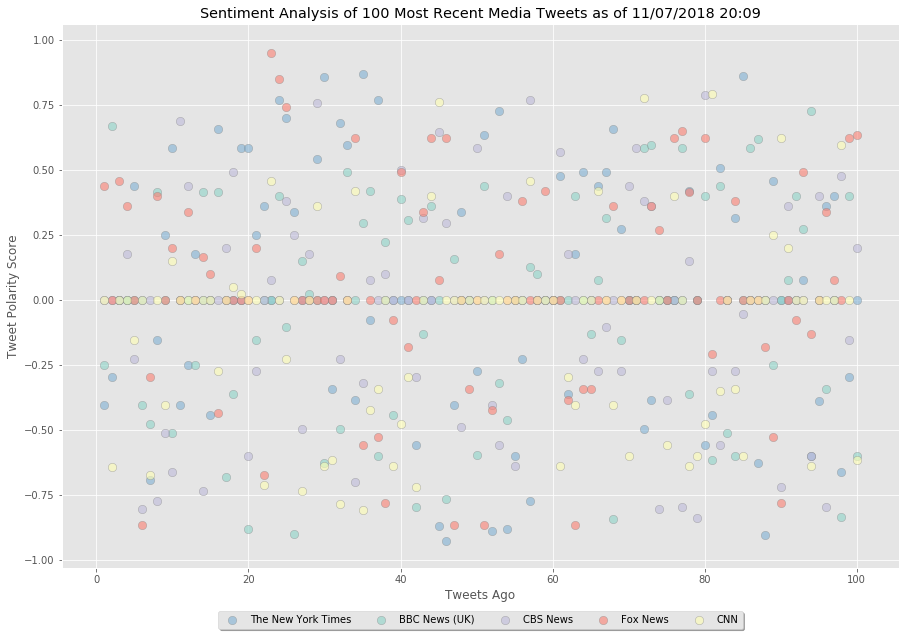

In [8]:
#get a datestamp in order to label the data
datestamp = datetime.now().strftime("%m/%d/%Y %H:%M")

#set plot size for easy reading
plt.figure(figsize = (15, 10))

#iterate through color mapping to create a subplot per news source
for i, dff in spd.groupby('source_key'):
    plt.scatter(dff['Tweets Ago'], dff['Compound'], s=70, c=i, edgecolors='grey', alpha=0.6, label=dff['Media Source'].unique()[0])

#set legend below the axis
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.07),
          fancybox=True, shadow=True, ncol=5)

#label the data
plt.title(f"Sentiment Analysis of 100 Most Recent Media Tweets as of {datestamp}")
plt.xlabel("Tweets Ago")
plt.ylabel("Tweet Polarity Score")

#save figure
plt.savefig('100_tweets_sentiments.png')
# show plot
plt.show()

### Overall Tweet Review

In [9]:
#group the sentiment dataframe by media source with color coding to get an average compound score
mean_sentiment = pd.DataFrame(spd.groupby(['Media Source', 'source_key'])['Compound'].mean()).reset_index(level='source_key')
mean_sentiment

,source_key,Compound
Media Source,,
BBC News (UK),#8dd3c7,-0.030813
CBS News,#bebada,-0.035499
CNN,#ffffb3,-0.095191
Fox News,#fb8072,0.042623
The New York Times,#80b1d3,0.026379


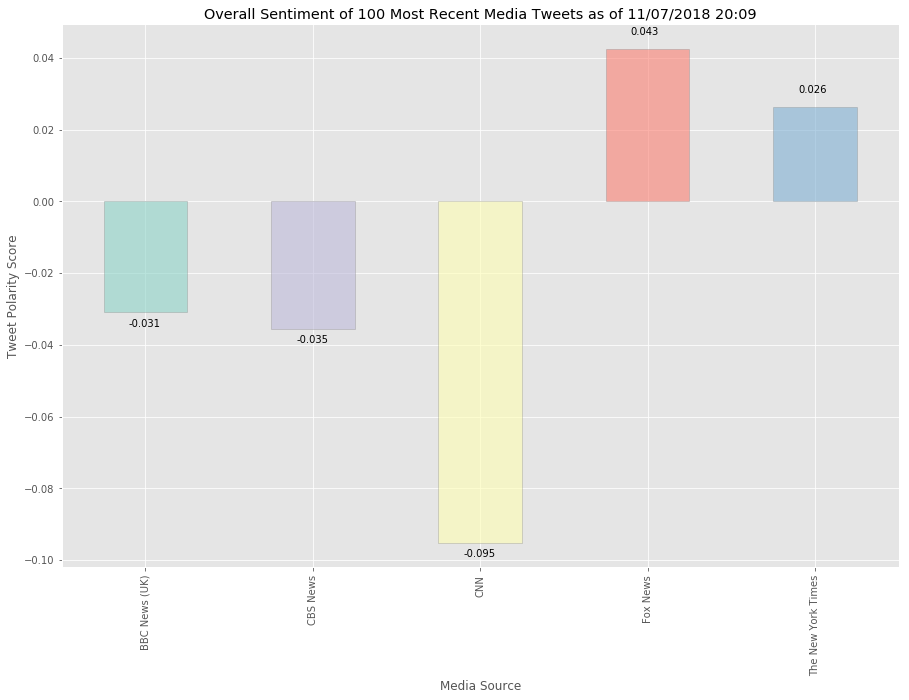

In [10]:
#set plot size for easy reading
plt.figure(figsize = (15, 10))

#plot the mean compound scores to review an overall sentiment in the last hour
o_plot = mean_sentiment['Compound'].plot(kind="bar", color=mean_sentiment['source_key'], edgecolor='grey', alpha=0.6)

#set aesthetics and titles
plt.title(f'Overall Sentiment of 100 Most Recent Media Tweets as of {datestamp}')
plt.xlabel('Media Source')
plt.ylabel('Tweet Polarity Score')

# Use a for loop to add column value labels
totals = []
for c in o_plot.patches:
    #capture the value
    y_val = c.get_height()
    #determine the position the label needs to be
    if y_val < 0:
        y_pos = y_val + -0.004
    else:
        y_pos = y_val + 0.004
    #write the text
    o_plot.text(c.get_x()+.15, y_pos, str(round(y_val,3)), fontsize=10, color='black')

# Save the Figure
plt.savefig('overall_tweet_sentiments.png')

# Show the Figure
plt.show()